In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import easyocr
import fitz  # PyMuPDF
import re
from PIL import Image
from image_cropping import crop_and_save_shooting_side_and_map_from_folder, crop_and_save_avg_formation_from_folder
from generate_graph import process_folder_with_fixed_pixel_grid, scale_mask, plot_heatmap, extract_xg_value, extract_attempts, extract_stats_from_image, process_folder_attack_side, plot_attack_side, extract_image_data,process_table_data, avg_formation_from_folder, plot_avg_formation 
from helper import find_team_folder, remove_pdfs_with_northwestern

In [9]:
team_name = "Penn State"
team_data_path = "../team-data/big-ten-combined-data.csv"
match_reports_path = "../match-reports"

In [2]:
try:
    folder_path = find_team_folder(team_name, match_reports_path)
    if folder_path:
        remove_pdfs_with_northwestern(folder_path)
        print("Matching folder path:", folder_path)
    else:
        print("No matching folder found.")
except FileNotFoundError as e:
    print(e)  

Removed: ../match-reports/penn-state-2024/Northwestern Wildcats - Penn State Nittany Lion 4-1.pdf
Matching folder path: ../match-reports/penn-state-2024


In [3]:
crop_and_save_shooting_side_and_map_from_folder(folder_path, team_name)
crop_and_save_avg_formation_from_folder(folder_path, team_name)

Cropped image saved as ../match-reports/penn-state-2024/home_team/shooting_map/shooting_map_1_Penn State_against_Rutgers Scarlet Knights 2.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/shooting_side/shooting_side_1_Penn State_against_Rutgers Scarlet Knights 2.png
Cropped image saved as ../match-reports/penn-state-2024/opp_team/shooting_map/shooting_map_1_Rutgers Scarlet Knights 2_against_Penn State.png
Cropped image saved as ../match-reports/penn-state-2024/opp_team/shooting_side/shooting_side_1_Rutgers Scarlet Knights 2_against_Penn State.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/shooting_map/shooting_map_2_Penn State_against_St John's Red Storm.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/shooting_side/shooting_side_2_Penn State_against_St John's Red Storm.png
Cropped image saved as ../match-reports/penn-state-2024/opp_team/shooting_map/shooting_map_2_St John's Red Storm_against_Penn State.png
Cropped image 

Cropped image saved as ../match-reports/penn-state-2024/home_team/avg_formation/avg_formation_4_Maryland College Park Terrapins_Penn State Nittany Lion 1.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/avg_formation/avg_formation_5_Penn State Nittany Lion_Michigan State Spartans 2.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/avg_formation/avg_formation_6_Indiana Hoosiers_Penn State Nittany Lion 2.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/avg_formation/avg_formation_7_Penn State Nittany Lion_Wisconsin Badgers 0.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/avg_formation/avg_formation_8_Penn State Nittany Lion_Ohio State Buckeyes 0.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/avg_formation/avg_formation_9_Penn State Nittany Lion_Army West Point Black Knights 2.png
Cropped image saved as ../match-reports/penn-state-2024/home_team/avg_formation/avg_formation_10_Penn S

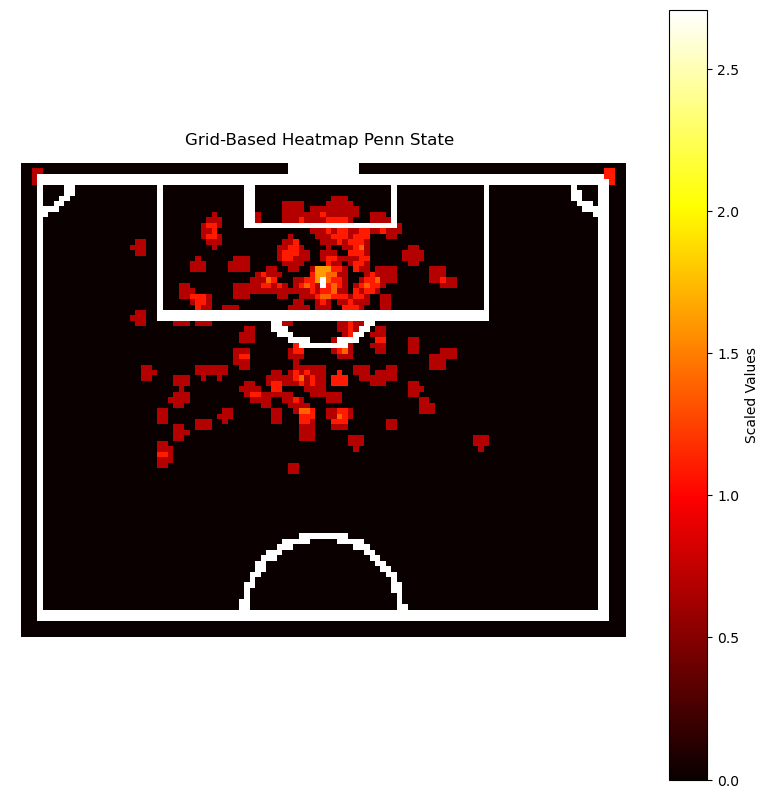

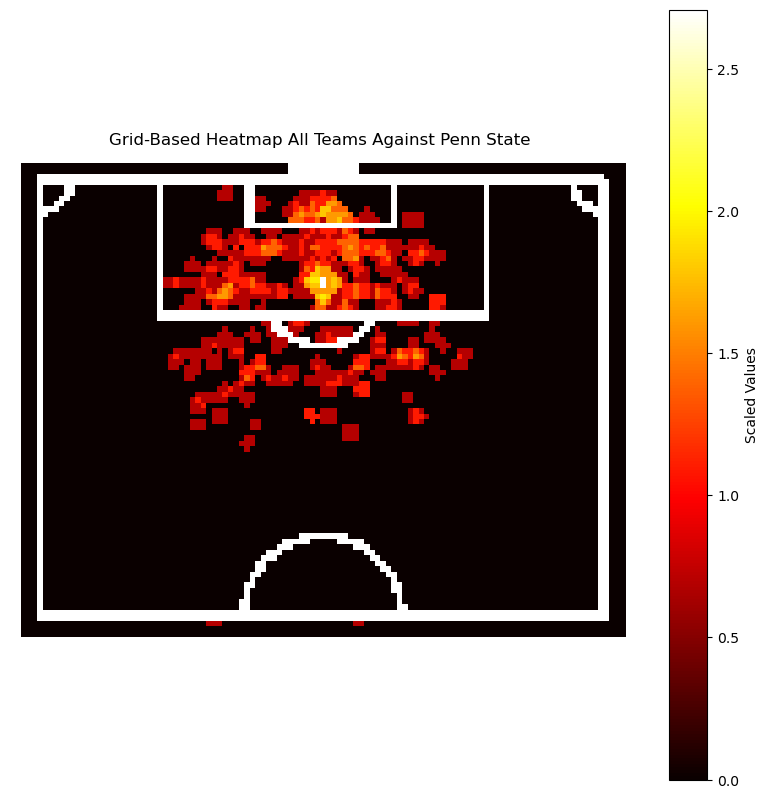

In [4]:
home_heat_map_path = os.path.join(folder_path, "home_team/shooting_map")
# Process the folder and generate the accumulated grid-based mask
home_accumulated_mask = process_folder_with_fixed_pixel_grid(home_heat_map_path, cell_size=(10, 10), threshold_fraction=0.1)

# Ensure the mask is not empty
if home_accumulated_mask is not None:
    # Plot the heatmap
    plot_heatmap(home_accumulated_mask, title=f"Grid-Based Heatmap {team_name}")
else:
    print("No images processed. Please check the folder path and contents.")
    
opp_heat_map_path = os.path.join(folder_path, "opp_team/shooting_map")
# Process the folder and generate the accumulated grid-based mask
opp_accumulated_mask = process_folder_with_fixed_pixel_grid(opp_heat_map_path, cell_size=(10, 10), threshold_fraction=0.1)

# Ensure the mask is not empty
if opp_accumulated_mask is not None:
    # Plot the heatmap
    plot_heatmap(opp_accumulated_mask, title=f"Grid-Based Heatmap All Teams Against {team_name}")
else:
    print("No images processed. Please check the folder path and contents.")
    

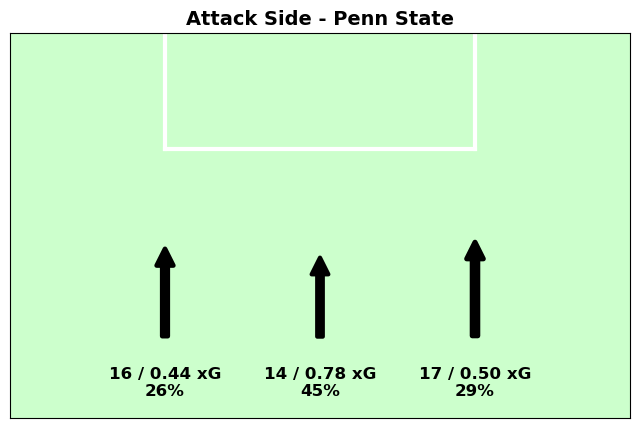

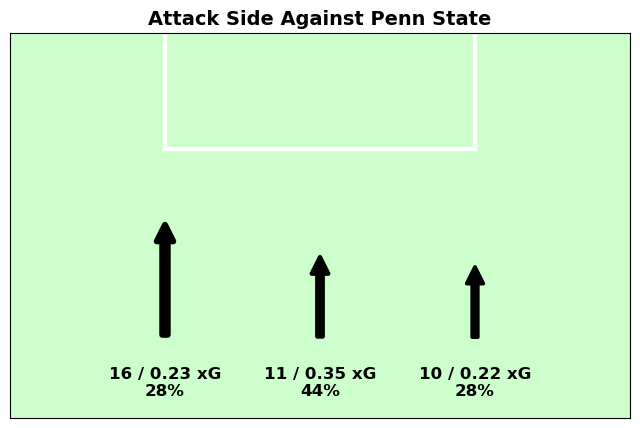

In [5]:
home_attack_side_path = os.path.join(folder_path, "home_team/shooting_side")
home_attack_side = process_folder_attack_side(home_attack_side_path)
opp_attack_side_path = os.path.join(folder_path, "opp_team/shooting_side")
opp_attack_side = process_folder_attack_side(opp_attack_side_path)
plot_attack_side(home_attack_side, title=f"Attack Side - {team_name}")
plot_attack_side(opp_attack_side, title=f"Attack Side Against {team_name}")

In [6]:
avg_formation_path = os.path.join(folder_path, "home_team/avg_formation")
avg_formation = avg_formation_from_folder(avg_formation_path, team_name)

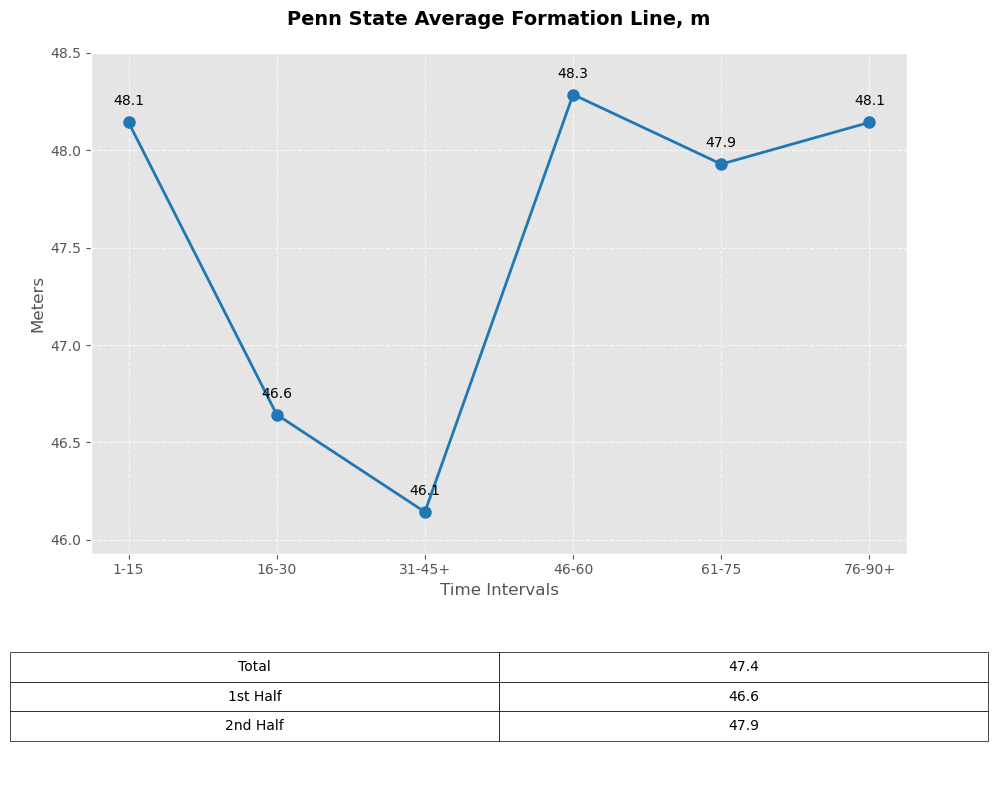

In [7]:
plot_avg_formation(avg_formation, team_name)

In [81]:
import pandas as pd
def get_team_data(team_data_path, team_name):
    team_data = pd.read_csv(team_data_path)
    team_data['team'] = team_data['team'].apply(lambda x: x.strip() if isinstance(x, str) else x)
    matching_teams = [team for team in team_data['team'].unique() if team_name.lower() in team.lower()]
    
    # Group by team and aggregate useful metrics
    team_summary = team_data.groupby('team').agg({
        'goals': 'sum',
        'xg': 'mean',
        'shots': 'sum',
        'sot': 'sum',
        'pass_success_rate': 'mean',
        'possession': 'mean',
        'losses': 'sum',
        'recoveries': 'sum',
        'tot_duels': 'sum',
        'tot_duels_won': 'sum',
        'tot_duels_win_rate': 'mean',
        'corners': 'sum',
        'fouls': 'sum',
        'yellows': 'sum',
        'reds': 'sum',
        'shots_against': 'sum',
        'goals_against': 'sum',
        'def_duels': 'sum',
        'interceptions': 'sum',
        'clearences': 'sum',
        'offsides': 'sum'
    }).reset_index()

    return team_summary[team_summary['team'] == matching_teams[0]]

def generate_prompt(team_summary, home_attack_side, avg_formation):
    team_data = team_summary.iloc[0]
    # Prepare the team statistics as a string
    team_stats_str = f"""
    - Team: {team_data['team']}
    - Goals: {team_data['goals']}
    - Expected Goals (xG): {team_data['xg']}
    - Shots: {team_data['shots']}
    - Shots on Target (SOT): {team_data['sot']}
    - Pass Success Rate: {team_data['pass_success_rate']}%
    - Possession: {team_data['possession']}%
    - Losses: {team_data['losses']}
    - Recoveries: {team_data['recoveries']}
    - Total Duels: {team_data['tot_duels']}
    - Corners: {team_data['corners']}
    - Fouls: {team_data['fouls']}
    - Yellow Cards: {team_data['yellows']}
    - Red Cards: {team_data['reds']}
    - Shots Against: {team_data['shots_against']}
    - Goals Against: {team_data['goals_against']}
    - Defensive Duels: {team_data['def_duels']}
    - Interceptions: {team_data['interceptions']}
    - Clearances: {team_data['clearences']}
    - Offsides: {team_data['offsides']}
    """

    # Attack side stats
    attack_side_str = f"""
    Attack Side Breakdown:
    - Left Side: {home_attack_side['left_attempts'].values[0]} attempts, xG: {home_attack_side['left_XG'].values[0]}
    - Middle: {home_attack_side['mid_attempts'].values[0]} attempts, xG: {home_attack_side['mid_XG'].values[0]}
    - Right Side: {home_attack_side['right_attempts'].values[0]} attempts, xG: {home_attack_side['right_XG'].values[0]}
    """

    # Average formation stats
    formation_str = f"""
    Average Formation Possession by Time Period:
    - Total: {avg_formation[avg_formation['index']=='Total'][0].values[0]}%
    """
    
    # Combine all the parts into one prompt
    prompt = f"""
    Analyze the strengths and weaknesses of the opposing team based on the following statistics:

    Team Stats:
    {team_stats_str}

    Attack Side Breakdown:
    {attack_side_str}

    Average Formation Possession:
    {formation_str}

    Provide insights on the team's weaknesses and strategies for exploiting them.
    """
    return prompt

In [90]:
team_summary = get_team_data(team_data_path, team_name)
prompt = generate_prompt(team_summary, home_attack_side, avg_formation)
system_message = "You are a soccer head coach."

In [91]:
prompt

"\n    Analyze the strengths and weaknesses of the opposing team based on the following statistics:\n\n    Team Stats:\n    \n    - Team: Penn State Nittany Lion\n    - Goals: 121\n    - Expected Goals (xG): 1.3975342465753424\n    - Shots: 794\n    - Shots on Target (SOT): 305\n    - Pass Success Rate: 77.41493150684931%\n    - Possession: 49.42465753424658%\n    - Losses: 9811\n    - Recoveries: 7198\n    - Total Duels: 17850\n    - Corners: 321\n    - Fouls: 838\n    - Yellow Cards: 102\n    - Red Cards: 7\n    - Shots Against: 929\n    - Goals Against: 93\n    - Defensive Duels: 5586\n    - Interceptions: 3640\n    - Clearances: 1434\n    - Offsides: 145\n    \n\n    Attack Side Breakdown:\n    \n    Attack Side Breakdown:\n    - Left Side: 16.428571428571427 attempts, xG: 0.4392857142857142\n    - Middle: 14.857142857142858 attempts, xG: 0.775\n    - Right Side: 17.615384615384617 attempts, xG: 0.4984615384615384\n    \n\n    Average Formation Possession:\n    \n    Average Format

In [92]:
from dotenv import load_dotenv
load_dotenv()

True

In [94]:
from openai import OpenAI
openai.api_key = os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key = openai.api_key)
# Make the API call to ChatGPT
response = client.chat.completions.create(
    model="gpt-4",
    messages=[
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt},
    ],
    max_tokens=200
)

# Output the analysis from ChatGPT
analysis = response.choices[0].message.content
print(analysis)

From the statistics provided for the Penn State Nittany Lion team, there are several points of strength and weakness that can be observed.

Strengths:
1. They have a high number of goals scored (121), which shows a strong attacking force.
2. Their high pass success rate (around 77%) suggests strong coordination and passing skills among team members.
3. A decent recovery statistic shows they are well-positioned to regain ball control after losing it.
4. They've produced a high number of shots (794) and shots on target (305), which could pose a threat.

Weaknesses:
1. Their Expected Goals (xG) is 1.398, which is relatively low compared to their actual goals scored. This demonstrates they could be overperforming or getting lucky in some matches, which might not be sustainable.
2. Their possession statistic is less than 50% which means they do not have control over the game most of the time. This could make them vulnerable
